# Fake Image Detection 

## Importing Labraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [3]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

## Making Dataset

In [56]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Convert to Error Level Analysis

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

## Comparison of Real and Fake image( fake images in ELA form)

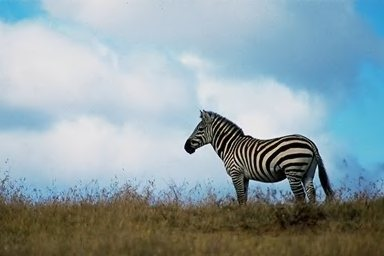

In [6]:
real_image_path = ('C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Au/Au_ani_00001.jpg')
#real_image_path = ('/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Real/Au_ani_00001.jpg')
Image.open(real_image_path)

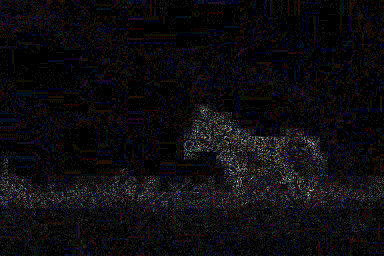

In [7]:
convert_to_ela_image(real_image_path, 90)

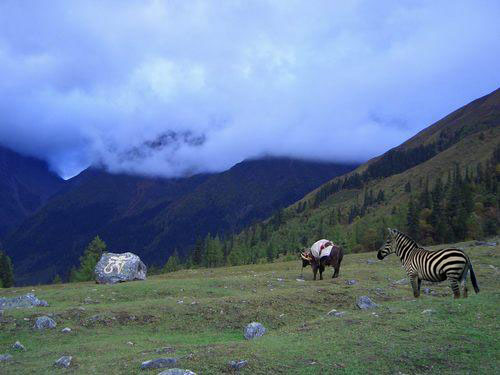

In [9]:
fake_image_path = ('C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg')
#fake_image_path = ('/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Fake/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg')
Image.open(fake_image_path)

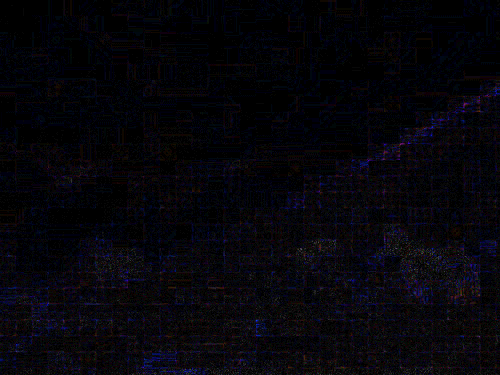

In [10]:
convert_to_ela_image(fake_image_path, 90)


## Data preparation

### Read dataset and conversion to ELA

In [11]:
#dataset = pd.read_csv('E:\\Summer 2020 Project\\FakeImageDetector-master\\dataset.csv')
#print(dataset)
image_size = (128, 128)

In [12]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [13]:
X = []
Y = []

In [14]:
import random
path = 'C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Au'
#path = '/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Real'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [15]:
path = 'C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Tp'
#path = '/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [16]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


## CNN building

In [18]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

### Model training

In [26]:
epochs = 5
batch_size = 32

In [27]:
from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr)

In [28]:
#init_lr = 1e-4
#optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

In [29]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [31]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/5
105/105 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.9237WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 155s 1s/step - loss: 0.2155 - accuracy: 0.9237 - val_loss: 0.2073 - val_accuracy: 0.9256
Epoch 2/5
105/105 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9279WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 135s 1s/step - loss: 0.1956 - accuracy: 0.9279 - val_loss: 0.1934 - val_accuracy: 0.9292
Epoch 3/5
105/105 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9349WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 143s 1s/step - loss: 0.1782 - accuracy: 0.9349 - val_loss: 0.1904 - val_accuracy: 0.9340
Epoch 4/5
105/105 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9400WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 166s 2s/step - loss: 0.1612 - accuracy: 0.9400 - val_loss: 0.1822 - val_accuracy: 0.9364
Epoch 5/5
105/105 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9490WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 336s 3s/step - loss: 0.1478 - accuracy: 0.9490 - val_loss: 0.1801 - val_accuracy: 0.9388


In [32]:
model.save('model_casia_run1.h5')

C:\Users\swapn\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


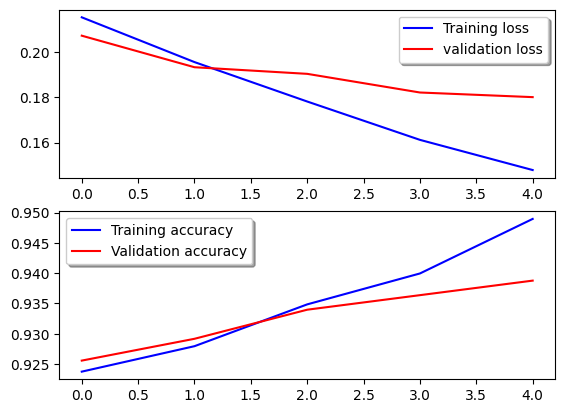

In [33]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

27/27 [==============================] - 5s 186ms/step


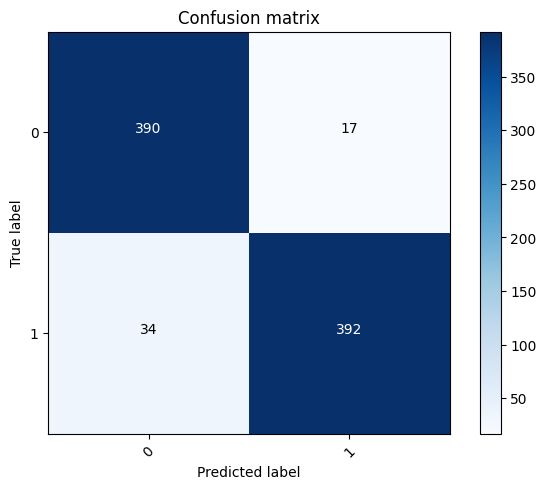

In [36]:
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [37]:
class_names = ['fake', 'real']

In [38]:
#real_image_path = '/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Real/Au_ani_00001.jpg'
real_image_path = 'C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 53ms/step
Class: real Confidence: 99.97


In [39]:
#fake_image_path = '/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Fake/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
fake_image_path = 'C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'

image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 59ms/step
Class: fake Confidence: 98.85


In [40]:
#fake_image = os.listdir('/content/drive/MyDrive/Colab Notebooks/Image_Detector/CASIA2/Fake/')
fake_image = os.listdir('C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 36ms/step


In [41]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2019, Acc: 97.81976744186046


In [42]:
real_image = os.listdir('C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('C:/Users/swapn/Downloads/mesonet/dataset/CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 66ms/step


In [43]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6725, Acc: 91.4468316562415
Total: 9418, Correct: 8744, Acc: 92.84349118708856
